# Helployee - a tool to monitor mobbing in the enterprises
## Brought to you by Snakey Snakes, January 2022

In this notebook we will present to you the *Helployee*. A tool to keep the employees safe and sound at the workplace. Keep in mind that this is just an Proof of Concept (PoC) that may be extended for future purposes. 

We will use vector methods and neural networks to solve the problem.*kursywa*

# Introductory steps

## Loading the data

First, we uploaded the data to Google Drive and mounted the colab notebook to Drive. We will extract data from the csvs from Drive and see the contents of directory.

The directory that we have created on my Google Drive is "snakey snakes"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# changing active directory
import os
os.chdir("/content/drive/MyDrive/snakey snakes")

In [4]:
# printing contents of the extracted directory
print(os.listdir(os.getcwd() + "/data"))

['aggression_parsed_dataset.csv', 'toxicity_parsed_dataset.csv']


In [5]:
# printing first row (header) from training sets to understend the structure
with open("data/toxicity_parsed_dataset.csv") as f:
    print(f.readline())

index,Text,ed_label_0,ed_label_1,oh_label



The data contains 5 columns. The ones that interest us is the second one (Text) and the last one (oh_label). Text is the document that we are analysing. Oh_label is the label that we are predicting (1 - suspicious, 0 - nonsuspicious)

We are kind of worried about the dataset. It is kind of low-quality (here we would like to remind the basic ML law: SISO, shit in shit out) and the results may be not that great. Nevertheless, this is the best that we could find for this PoC. But no worries - we will manage it!

## Building pandas data frames

For data processing we have decided to use pandas to handle data. Pandas is not a speed demon but this dataset is not that huge.

In the next few cells, we will load  files to pandas data frames and transform them to result in a training and test data frame for further analysis.

In [6]:
# importing pandas
import pandas as pd

In [7]:
train_ = pd.read_csv("data/toxicity_parsed_dataset.csv", encoding='latin1')
train_ = pd.concat([train_, pd.read_csv("data/aggression_parsed_dataset.csv", encoding='latin1')], ignore_index = True)
train_

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,This: :One can make an analogy in mathematical...,0.900000,0.100000,0
1,1,` :Clarification for you (and Zundark's righ...,1.000000,0.000000,0
2,2,Elected or Electoral? JHK,1.000000,0.000000,0
3,3,`This is such a fun entry. Devotchka I once...,1.000000,0.000000,0
4,4,Please relate the ozone hole to increases in c...,0.800000,0.200000,0
...,...,...,...,...,...
275545,115859,` These sources don't exactly exude a sense ...,0.777778,0.222222,0
275546,115860,The Institute for Historical Review is a pee...,1.000000,0.000000,0
275547,115861,:The way you're trying to describe it in this...,1.000000,0.000000,0
275548,115862,== Warning == There is clearly a protection...,0.500000,0.500000,0


In [8]:
print("How many suspicious examples: {}".format(train_["oh_label"].sum()))

How many suspicious examples: 30144


In [9]:
# preliminary data cleaning
train_['Text'] = train_['Text'].str.replace('http\S+|www.\S+|@\S+', '', case=False) #remove mentions and urls
train = train_.loc[:,["Text", "oh_label"]]
train.columns = ["text", "suspicious"]

In [10]:
# shuffling the dataset
from sklearn.utils import shuffle
train = shuffle(train)
train.head()
train

,text,suspicious
39063,: Thanks for the explanation!,0
53633,:I'm sure it was worth every penny... â,0
274393,"`:Hi, â thank you for discussing this, alth...",0
199098,"` :::::::Sorry, but Cambridge does not define ...",0
117739,", and is less cheesecake than the one from BeC...",0
...,...,...
97588,== Cafe World == We need to make a article...,0
90494,` == Thank you == Hello and thank you for re...,0
78581,` ::::``you Will be blocked`` is much differen...,0
139406,"Thank you for asking, but I'm not sure I real...",0


Next we will spilt train to train and test

In [11]:
# building cumulative test data frame
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, shuffle=False, test_size=0.1)
display(test.head())
print("Test length is {}".format(len(test)))
display(train.head())
print("Train length is {}".format(len(train)))

,text,suspicious
249195,He's made yet another sock as FrankGrant.,0
57485,== Jimbo photo in Advertising Age magazine =...,0
264527,Established romanization conventions for vari...,0
134276,"` ==Climate Change Photo== Hello, obviously y...",0
42126,` â ÎÅÅÅ Îµâ u suck loser. go kill urs...,1


Test length is 27555


,text,suspicious
39063,: Thanks for the explanation!,0
53633,:I'm sure it was worth every penny... â,0
274393,"`:Hi, â thank you for discussing this, alth...",0
199098,"` :::::::Sorry, but Cambridge does not define ...",0
117739,", and is less cheesecake than the one from BeC...",0


Train length is 247995


In [12]:
print("Number of suspicious in test set is {}".format(test["suspicious"].sum()))
print("Number of nonsuspicious in test set is {}".format(len(test)-test["suspicious"].sum()))
print("Number of suspicious in train set is {}".format(train["suspicious"].sum()))
print("Number of nonsuspicious in train set is {}".format(len(train)-train["suspicious"].sum()))

Number of suspicious in test set is 3067
Number of nonsuspicious in test set is 24488
Number of suspicious in train set is 27077
Number of nonsuspicious in train set is 220918


# Explorative Data Analysis & Preprocessing

## Preliminary Data Exploration

In [ ]:
# for visualizations we will be using matplotlib
import matplotlib.pyplot as plt

In the preliminary data exploration step, we will draw a histogram of documents' lengths.

Probably other preliminary EDA could be performed (e.g., language diversity or language detection), but this is just a concept, so we will not dive too deep into the analysis

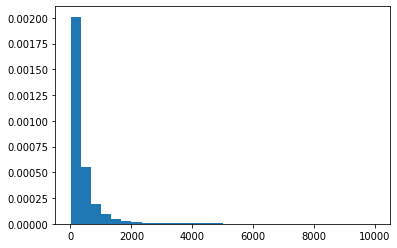

In [ ]:
# plotting the histogram of documents' lengths
lengths = train["text"].apply(lambda x: len(x)).values
plt.hist(lengths, density=True, bins=30)
plt.show()

From the histogram we can see that the lengths of the documents are very uneven - this may cause problems to our dataset. There is a big chunk of documents that seem to be super short

In [ ]:
# checking out too short documents
print(train["text"].str.len().nsmallest(10))
print(train.loc[train["text"].str.len() <=3, "text"])

31433     3
182601    3
30068     3
130694    3
131187    4
236397    5
121843    5
262610    5
248268    5
2898      5
Name: text, dtype: int64
31433        
182601       
30068        
130694       
Name: text, dtype: object


In [ ]:
# The documents shorter than 4 characters do not bring information to the data
# thus we decided to remove them
train = train.loc[train["text"].str.len()>3, :]

At this step it could be useful to perform other steps (like language detection, word lengths analysis, language diversity, etc). We won't do that in this PoC as it takes too much computational power to do so.

## Preprocessing

We will preprocess the data on the basic level for the later analysis. Ideally we would start the preprocessing with translating non English documents.

We are going to:

*   trasform  documents to lowercase,
*   remove cotractions (n't),
*   remove special characters,
*   remove stopwords,
*   remove custom stop words (stopwords specific to this dataset)
*   and lemmatize


*In the real life example the number of transformations combinations and propositions would probably be much bigger but this is just a PoC so we will perform preprocessing only once*

In [13]:
# the main preprocessing pipeline
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def contractions(s):
 s = re.sub(r"won't", "will not",s)
 s = re.sub(r"would't", "would not",s)
 s = re.sub(r"could't", "could not",s)
 s = re.sub(r"\'d", " would",s)
 s = re.sub(r"can\'t", "can not",s)
 s = re.sub(r"n\'t", " not", s)
 s = re.sub(r"\'re", " are", s)
 s = re.sub(r"\'s", " is", s)
 s = re.sub(r"\'ll", " will", s)
 s = re.sub(r"\'t", " not", s)
 s = re.sub(r"\'ve", " have", s)
 s = re.sub(r"\'m", " am", s)
 s = re.sub(r" u ", " you ", s)
 s = re.sub(r" ur ", " your ", s)
 return s

def preprocess(data):
  # transforming to lowercase
  data['clean'] = data['text'].apply(lambda x: x.lower())
  # removing contractions
  data['clean'] = data["clean"].apply(lambda x: contractions(x))
  # removing punctuation
  data['clean'] = data['clean'].apply(lambda x: ' '.join(''.join(' ' if c in string.punctuation else c for c in x).split()))
  # removing multiple spaces
  data['clean'] = data['clean'].apply(lambda x: re.sub(' +', ' ', x))
  # removing stopwords
  stop = stopwords.words('english') # common
  stop.extend(["wikipedia", "wiki", "article", "page", "en", "org"]) #custom
  data['clean'] = data['clean'].apply(lambda x: ' '.join([x for x in x.split() if x not in stop]))
  # lemmatize
  lemmatizer = WordNetLemmatizer()
  data['clean'] = data['clean'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
  
  return data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# running the preprocessing
%%time
train = preprocess(train)
test = preprocess(test)

CPU times: user 3min 6s, sys: 931 ms, total: 3min 7s
Wall time: 3min 8s


In [ ]:
# results
train.head()

,text,suspicious,clean
118556,Mentioning of over seas distribution == I hav...,0,mentioning sea distribution noticed no energy ...
273828,"Go use your drugs, insignificant nobody. ...",1,go use drug insignificant nobody eraser stalke...
204113,FUCKING SUCK YOU LIBERAL BASTARD WHO THINKS MI...,1,fucking suck liberal bastard think michael moo...
110142,"::They're observations, not insults. No offe...",0,observation insult offence intended
175052,You can't just use Beirut as the main pictur...,0,use beirut main picture thousand missile fired...


In [ ]:
# dump of preprocessed data for the future
train.to_csv("train_preprocessed.csv")
test.to_csv("test_preprocessed.csv")

In [ ]:
# reading the data from file
train = pd.read_csv("train_preprocessed.csv", index_col=0)
test = pd.read_csv("test_preprocessed.csv", index_col=0)

## Data Exploration continued

After data preprocessing step we decided to explore the contents of the documents a little bit to better understand the dataset.

First we will draw a word cloud and word frequency bar chart to get a basic look at the contents.

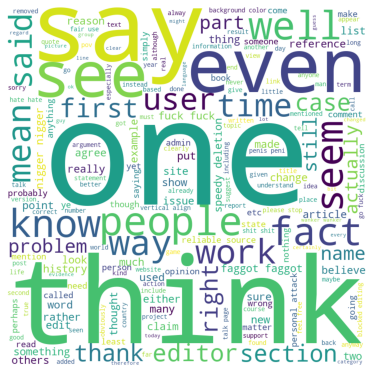

In [ ]:
# drawing word cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10)\
                .generate(' '.join(train['clean'].astype(str)[10000:])) 
                #using only sample because we don't have that much 
                #time to wait for wordcloud to generate for this many documents:)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
# praparing data for the word frequency diagram
from collections import Counter
import numpy as np
terms = (' '.join(train['clean'].astype(str))).split()
counts = dict(Counter(terms).most_common(30)) #take only top 30 words
print(counts)
labels, values = zip(*counts.items())

{'would': 55966, 'one': 48290, 'like': 46325, 'please': 43851, 'talk': 35659, 'source': 33189, 'see': 33102, 'think': 32742, 'know': 32443, 'also': 32110, 'people': 31076, 'time': 30372, 'edit': 27678, 'make': 25502, 'article': 24771, 'use': 24234, 'get': 23720, 'user': 23421, 'say': 23037, 'may': 22694, 'fuck': 21976, 'even': 21900, 'need': 21563, 'image': 20739, 'name': 20735, 'link': 20219, 'want': 20215, 'thanks': 20137, 'good': 19963, 'go': 19911}


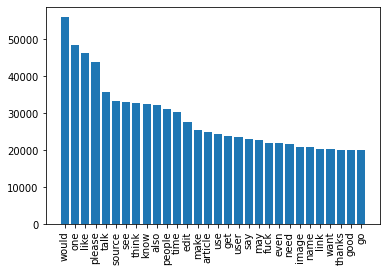

In [ ]:
# plotting word frequencies
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.show()

There are no strcitly "too common" words. 

We see that we can remove some more custom stop words - e.g. would, get, u, also. These would probably improve our algorithm. We will not do it here, this is just PoC, in the real analysis removing this words would be worth checking out.

Next, we will proceed with drawing the bigrams to know the dataset even better

In [ ]:
# preparing data for the bigrams frequencies chart
bigrams = [bigram for document in train['clean'].astype(str)\
           for bigram in zip(document.split(" ")[:-1], document.split(" ")[1:])]
counts_bi = dict(Counter(bigrams).most_common(30)) #take only top 30 words
print(counts_bi)
labels_bi, values_bi = zip(*counts_bi.items())
labels_bi = [' '.join(bigram) for bigram in labels_bi]

{('would', 'like'): 7181, ('faggot', 'faggot'): 6204, ('nigger', 'nigger'): 6009, ('speedy', 'deletion'): 5626, ('can', 'not'): 5003, ('personal', 'attack'): 4854, ('hate', 'hate'): 4853, ('reliable', 'source'): 4839, ('fuck', 'fuck'): 4720, ('background', 'color'): 4320, ('fair', 'use'): 4214, ('vertical', 'align'): 4205, ('shit', 'shit'): 3838, ('feel', 'free'): 3298, ('please', 'stop'): 3265, ('talk', 'page'): 3240, ('blocked', 'editing'): 3184, ('as', 'as'): 2974, ('penis', 'penis'): 2900, ('go', 'fuck'): 2796, ('moron', 'hi'): 2772, ('hi', 'moron'): 2770, ('ip', 'address'): 2656, ('style', 'vertical'): 2655, ('wanker', 'wanker'): 2619, ('edit', 'summary'): 2609, ('point', 'view'): 2539, ('look', 'like'): 2530, ('bla', 'bla'): 2524, ('1px', 'solid'): 2478}


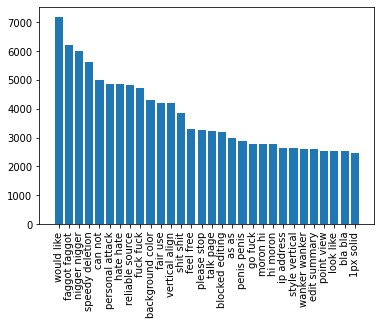

In [ ]:
# drawing the bigrams frequencies chart
plt.bar(labels_bi, values_bi)
plt.xticks(rotation=90)
plt.show()

With bigrams we can observe the contents of the dataset in greater context. The most common bigrams are of course offensive words :) we love the internet users

# Basic Classification Methods

Our first go is to use vector/reggresion-like methods to solve this NLP problem. Vectors are much less computionally expensive than neural networks and in many cases they work really well. We want to give it a go and see what happens.

## Building self-designed models

Finally we can start building the models :). First, we are building train and test feature vectors based on TF-IDF matrix. The class to be predicted is the "suspicious" column. 

In [ ]:
# setting the training and testing vectors
X_train_sentences, X_test_sentences, Y_train, Y_test = train['clean'].astype(str), test['clean'].astype(str), train['suspicious'], test['suspicious']
# building tf-idf feautre matrix
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_sentences)
X_test = vectorizer.transform(X_test_sentences)

In [ ]:
!pip install pickle-mixin
import _pickle as cPickle
# saving the vectorizer for the API
with open('vectorizer.pkl', 'wb') as fid:
    cPickle.dump(vectorizer, fid)

We will try to build different models to predict the offensive documents. The assessment of results will be provided by the sklearn classification_report function. In the end of this analysis we will perform a comparison of the outcomes.

In [ ]:
# evaluation dictionary
from sklearn.metrics import classification_report
results = {}

### SVM algorithm

In [ ]:
%%time
# building and testing svm model
from sklearn.svm import LinearSVC
svm_model = LinearSVC(random_state = 0)
svm_model.fit(X_train, Y_train)
y_test_pred = svm_model.predict(X_test)

CPU times: user 4.41 s, sys: 23.8 ms, total: 4.43 s
Wall time: 4.42 s


In [ ]:
# save the classifier
with open('svm_classifier.pkl', 'wb') as fid:
    cPickle.dump(svm_model, fid)    

In [ ]:
# testing the results
results["svm"] = classification_report(Y_test, y_test_pred, output_dict = True)
results["svm"]

{'0': {'f1-score': 0.976086428744841,
  'precision': 0.9673189509984762,
  'recall': 0.9850142915475705,
  'support': 24490},
 '1': {'f1-score': 0.7919746568109821,
  'precision': 0.8597630875047765,
  'recall': 0.734094616639478,
  'support': 3065},
 'accuracy': 0.9571039738704409,
 'macro avg': {'f1-score': 0.8840305427779116,
  'precision': 0.9135410192516263,
  'recall': 0.8595544540935243,
  'support': 27555},
 'weighted avg': {'f1-score': 0.955607293162287,
  'precision': 0.9553552884469179,
  'recall': 0.9571039738704409,
  'support': 27555}}

### Logistic regression

In [ ]:
%%time
# building and testing logistic reggression model

from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter = 1000, solver='saga')
lr_model.fit(X_train, Y_train)
y_test_pred = lr_model.predict(X_test)

CPU times: user 7.92 s, sys: 14.3 ms, total: 7.94 s
Wall time: 7.96 s


In [ ]:
# testing the results
results["lr"] = classification_report(Y_test, y_test_pred,output_dict=True)
results["lr"]

{'0': {'f1-score': 0.9723296399446993,
  'precision': 0.9545615484480113,
  'recall': 0.9907717435688036,
  'support': 24490},
 '1': {'f1-score': 0.7344741395885407,
  'precision': 0.8941947565543071,
  'recall': 0.6231647634584013,
  'support': 3065},
 'accuracy': 0.9498820540736709,
 'macro avg': {'f1-score': 0.85340188976662,
  'precision': 0.9243781525011592,
  'recall': 0.8069682535136025,
  'support': 27555},
 'weighted avg': {'f1-score': 0.9458724775933429,
  'precision': 0.9478468245447559,
  'recall': 0.9498820540736709,
  'support': 27555}}

### Bayes Naive Classifier

In [ ]:
%%time
# building and testing naive bayes classifier model

from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, Y_train)
y_test_pred = nb_model.predict(X_test)

CPU times: user 153 ms, sys: 3.75 ms, total: 157 ms
Wall time: 162 ms


In [ ]:
# testing the results
results["nb"] = classification_report(Y_test, y_test_pred,output_dict=True)
results["nb"]

{'0': {'f1-score': 0.9573997612664619,
  'precision': 0.9192124149851576,
  'recall': 0.9988975091874235,
  'support': 24490},
 '1': {'f1-score': 0.4567007736461193,
  'precision': 0.9713375796178344,
  'recall': 0.29853181076672103,
  'support': 3065},
 'accuracy': 0.9209943748865904,
 'macro avg': {'f1-score': 0.7070502674562906,
  'precision': 0.945274997301496,
  'recall': 0.6487146599770722,
  'support': 27555},
 'weighted avg': {'f1-score': 0.9017059707726731,
  'precision': 0.9250104055349364,
  'recall': 0.9209943748865904,
  'support': 27555}}

### Comparison

In [ ]:
# printing cumulative results
import json
print(json.dumps(results, indent=4))

{
    "svm": {
        "0": {
            "precision": 0.9673189509984762,
            "recall": 0.9850142915475705,
            "f1-score": 0.976086428744841,
            "support": 24490
        },
        "1": {
            "precision": 0.8597630875047765,
            "recall": 0.734094616639478,
            "f1-score": 0.7919746568109821,
            "support": 3065
        },
        "accuracy": 0.9571039738704409,
        "macro avg": {
            "precision": 0.9135410192516263,
            "recall": 0.8595544540935243,
            "f1-score": 0.8840305427779116,
            "support": 27555
        },
        "weighted avg": {
            "precision": 0.9553552884469179,
            "recall": 0.9571039738704409,
            "f1-score": 0.955607293162287,
            "support": 27555
        }
    },
    "lr": {
        "0": {
            "precision": 0.9545615484480113,
            "recall": 0.9907717435688036,
            "f1-score": 0.9723296399446993,
            "support":

### Conclusions

Naive Bayer Classifier and Logistic Regression are just a no-no for this task. They total missperform and are useless in this task with this dataset.

SVM seems to be an okay option. It does not give superior results but f1 scores oscilating within the 0.9 mark are acceptable for this kind of PoC with such a limited time bounds. We also appreciete the easiness of use of the SVM method and the fact that it trains within seconds (not hours like neural network that will be presented below).

As we are not fully satisfied with the results provided by SVM, in the next part of this paper we will proceed to build a neural network as it may be more useful detecting e.g. sarcasm and other hidden meanings in the text.

For now we think that SVM performed the best and if any, would suggest using SVM for further reseach :)

In [ ]:
####HOW TO USE IN THE API####
from sklearn.feature_extraction.text import TfidfVectorizer
import _pickle as cPickle

# the main preprocessing pipeline
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def contractions(s):
 s = re.sub(r"won't", "will not",s)
 s = re.sub(r"would't", "would not",s)
 s = re.sub(r"could't", "could not",s)
 s = re.sub(r"\'d", " would",s)
 s = re.sub(r"can\'t", "can not",s)
 s = re.sub(r"n\'t", " not", s)
 s = re.sub(r"\'re", " are", s)
 s = re.sub(r"\'s", " is", s)
 s = re.sub(r"\'ll", " will", s)
 s = re.sub(r"\'t", " not", s)
 s = re.sub(r"\'ve", " have", s)
 s = re.sub(r"\'m", " am", s)
 return s

def preprocess(sentence):
  sentence = contractions(sentence.lower())
  sentence = ' '.join(''.join(' ' if c in string.punctuation else c for c in sentence).split())
  sentence = re.sub(' +', ' ', sentence)
  stop = stopwords.words('english')
  sentence =  ' '.join([sentence for sentence in sentence.split() if sentence not in stop])
  lemmatizer = WordNetLemmatizer()
  sentence = ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(sentence)])
  return sentence

with open('vectorizer.pkl', 'rb') as fid:
    vectorizer = cPickle.load(fid)
with open('svm_classifier.pkl', 'rb') as fid:
    svm_model = cPickle.load(fid)
sentence = "i can't believe how stupid u are"
sentence = preprocess(sentence)
X_test_ = vectorizer.transform([sentence])
y_test_pred_ = svm_model.predict(X_test_)
print("prediction: {}".format(y_test_pred_[0]))

# Neural Networks

In [14]:
# importing necessary libraries
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

In [15]:
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )

## Moving to Keras

In this part of the devolpment we decided to focus on the use of deep neural networks to achieve the main goal of our solution.

We took our pandas dataframe and transformed it to tensorflow's dataset to further prepare it for purposes of using in the training of our chosen neural network. In order to train the network more efficiently we decided to randomly sample 25% of our original dataset. 

Since our dataset is significantly unbalanced we decided to downsample majority class to be the same amount as our minority class.

In [48]:
data = train_.loc[:,["Text", "oh_label"]]
data.columns = ["text", "suspicious"]
data = preprocess(data)
#data = data.sample(frac = 0.25, replace=False, random_state=42)
train, validate, test = np.split(data.sample(frac=1, random_state=42), 
                        [int(.8*len(data)), int(.9*len(data))])
train = downsample(train, 'suspicious')
train_ds = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train['clean'].values, tf.string),
            tf.cast(train['suspicious'].values, tf.int64)
        )
    )
)
valid_ds = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(validate['clean'].values, tf.string),
            tf.cast(validate['suspicious'].values, tf.int64)
        )
    )
)
test_ds = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test['clean'].values, tf.string),
            tf.cast(test['suspicious'].values, tf.int64)
        )
    )
)

In [93]:
len(train)

48150

In [49]:
for text, sus in train_ds.take(1):
  print('text: ', text.numpy())
  print('label: ', sus.numpy())

text:  b'effendi mehmet oglu aka john stevens posting controversial material per say copy pasting information exact wording web site search first line material google find exact thing several propaganda site'
label:  0


We split our dataset in to 3 seperate sets for training, validating and lastly testing. Chosen proporotions were 8:1:1 for those sets.

In [50]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [51]:
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [52]:
train_ds.element_spec


(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

##Prepare encoder

We use build in vectorizer provided by Keras framework to process our raw text.

In [53]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))

In [54]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'fuck', 'like', 'suck', 'nigger', 'would', 'shit',
       'one', 'faggot', 'know', 'go', 'people', 'please', 'as', 'get',
       'talk', 'fucking', 'think', 'time'], dtype='<U17')

In [55]:
encoded_example = encoder(text).numpy()
encoded_example

array([  1,   1,   1,   1, 442,   1, 852,   1, 321, 567,  34, 782,   1,
        52,   1,   1, 628, 134, 707,  76, 348, 321, 676, 101,   1,  46,
       370, 871, 134])

##Model and training 

Model we chose as solution to our problem is RNN model built using keras.Sequential. It consists of previously created encoder, embedding layer, bidirectional RNN layer and two dense layers with final one being our classification output. 

In [87]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

We compile the model with Binary Crossentropy as our chosen loss function. Our optimizer of choise is Adam with learning rate of 0.0001 and our metric is basic accuracy function provided by Keras.

In [88]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [89]:
history = model.fit(train_ds, epochs=25,
                    validation_data=valid_ds,
                    validation_steps=10)


Epoch 1/25
377/377 [==============================] - 27s 63ms/step - loss: 0.5123 - accuracy: 0.7219 - val_loss: 2.1771 - val_accuracy: 0.1078
Epoch 2/25
377/377 [==============================] - 23s 61ms/step - loss: 0.6078 - accuracy: 0.6711 - val_loss: 1.8768 - val_accuracy: 0.1422
Epoch 3/25
377/377 [==============================] - 22s 59ms/step - loss: 0.4892 - accuracy: 0.7463 - val_loss: 1.5047 - val_accuracy: 0.2719
Epoch 4/25
377/377 [==============================] - 23s 61ms/step - loss: 0.3676 - accuracy: 0.8348 - val_loss: 1.3154 - val_accuracy: 0.4180
Epoch 5/25
377/377 [==============================] - 23s 61ms/step - loss: 0.2911 - accuracy: 0.8698 - val_loss: 1.1230 - val_accuracy: 0.5359
Epoch 6/25
377/377 [==============================] - 23s 61ms/step - loss: 0.2488 - accuracy: 0.8919 - val_loss: 1.0753 - val_accuracy: 0.5883
Epoch 7/25
377/377 [==============================] - 23s 60ms/step - loss: 0.2309 - accuracy: 0.8995 - val_loss: 1.0214 - val_accuracy:

In [91]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


216/216 [==============================] - 4s 19ms/step - loss: 0.8037 - accuracy: 0.6972
Test Loss: 0.8037212491035461
Test Accuracy: 0.6971511244773865


In [60]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


(0.0, 2.2144447185099123)

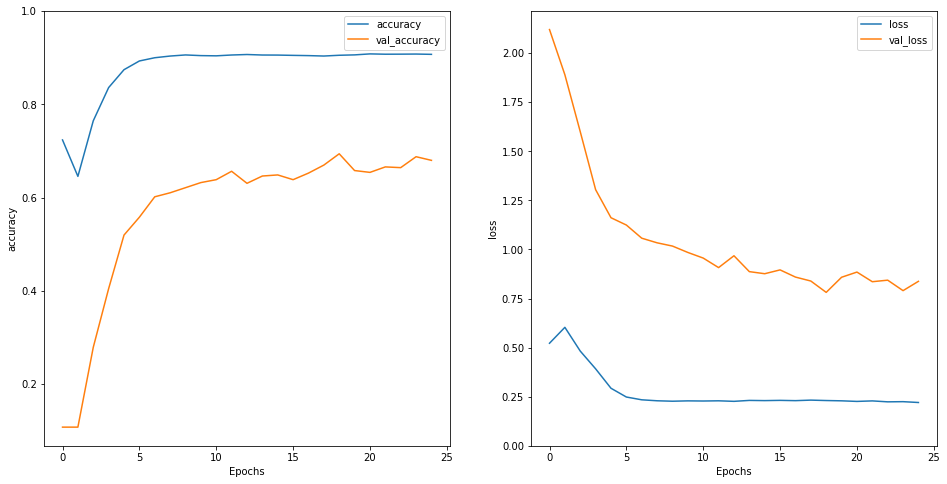

In [61]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [71]:
model.save('model_weights')

INFO:tensorflow:Assets written to: model_weights/assets


INFO:tensorflow:Assets written to: model_weights/assets


In [72]:
from tensorflow import keras
model_loaded = keras.models.load_model('model_weights', compile=False)

In [67]:
sample_text = ("last day was a fucking nightmare")
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[7.1477656]]


In [77]:
y_predictions = model.predict(test_ds)
y_predictions[:10]

array([[-3.3562288 ],
       [-2.7909951 ],
       [ 0.20417944],
       [-2.7149649 ],
       [ 0.15086204],
       [-0.6993477 ],
       [-2.000164  ],
       [-1.115947  ],
       [ 2.9214132 ],
       [-1.7211962 ]], dtype=float32)

In [84]:
y_predictions_df = pd.DataFrame(y_predictions)
y_predictions_df.columns = ["score"]
y_predictions_df["pred_label"] = y_predictions_df["score"]
y_predictions_df.loc[y_predictions_df["score"]>=0, "pred_label"] = 1
y_predictions_df.loc[y_predictions_df["score"]<0, "pred_label"] = 0
y_predictions_df["real_label"] = test["suspicious"].reset_index()["suspicious"]
y_predictions_df

,score,pred_label,real_label
0,-3.356229,0.0,0
1,-2.790995,0.0,0
2,0.204179,1.0,0
3,-2.714965,0.0,0
4,0.150862,1.0,0
...,...,...,...
27550,1.225941,1.0,0
27551,0.278514,1.0,0
27552,0.163136,1.0,0
27553,-2.745737,0.0,0


In [85]:
# evaluation dictionary
from sklearn.metrics import classification_report
classification_report(y_predictions_df["real_label"], y_predictions_df["pred_label"], output_dict = True)

{'0': {'f1-score': 0.7306117192530587,
  'precision': 0.9945305378304466,
  'recall': 0.5773896759485426,
  'support': 24564},
 '1': {'f1-score': 0.3577525330058336,
  'precision': 0.21912140815405445,
  'recall': 0.9739217652958877,
  'support': 2991},
 'accuracy': 0.620431863545636,
 'macro avg': {'f1-score': 0.5441821261294462,
  'precision': 0.6068259729922505,
  'recall': 0.7756557206222152,
  'support': 27555},
 'weighted avg': {'f1-score': 0.6901391434568165,
  'precision': 0.9103625571785835,
  'recall': 0.620431863545636,
  'support': 27555}}

## Summary

Our trained model unfortunetly misses the mark. Change in training accuracy is quite promising while fluctuating validation loss and accuracy may point to overfitting. Our model correctly predicts obvious examples of abuse while struggling with more nuanced cases. We believe that best solution for immediate improvements of obtained results would be to acquire more data representive of the day to day conversations in the companies. We tried :')


# That's it :)

This would probably wrap up our analysis for now we guess.

We wanted to do some more cool stuff with the data but we think that this document is getting too long anyways.

Have a nice day :))